# 1. Import des bibliothèques  
Importation des modules pour le traitement, pipeline et modèles.

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib, os
pd.set_option('display.max_columns', None)

# 2. Chargement des données  
Lecture du fichier CSV des features d’achats et aperçu.

In [3]:
data = '../Features/Export_fe_data/achats_merged_features.csv'
df = pd.read_csv(data)
print(df.shape)
df.head()

(10000, 17)


,id_achat,date_achat,id_produit,quantité,id_fournisseur,prix_unitaire,délai_livraison_jours,nom_fournisseur,ville,pays,fiabilité,délai_moyen_jours,cout_total,delai_deviation,retard_jours,mois_achat,on_time_delivery
0,PO000001,2024-03-22,P00627,150,S029,129.62,14,Fontaine Lopes S.A.,Helsinki,Finlande,0.54,6,19443.0,8,8,3,0
1,PO000002,2024-06-12,P00469,50,S028,110.81,8,Delattre Blot S.A.,Berlin,Allemagne,0.74,8,5540.5,0,0,6,1
2,PO000003,2024-01-19,P00849,75,S001,140.58,8,Lecomte et Fils,Zurich,Suisse,0.84,10,10543.5,-2,0,1,1
3,PO000004,2024-11-20,P00484,500,S028,120.77,9,Delattre Blot S.A.,Berlin,Allemagne,0.74,8,60385.0,1,1,11,0
4,PO000005,2024-06-07,P00196,50,S025,256.05,13,Techer SA,Varsovie,Pologne,0.92,12,12802.5,1,1,6,0


# 3. Nettoyage initial  
Suppression des colonnes non utilisées pour éviter la fuite.

In [4]:
df = df.drop(columns=['délai_livraison_jours', 'delai_deviation','retard_jours'])

# 4. Prétraitement et encodage  
Séparation de X, y et encodage one-hot pour les catégorielles.

In [5]:
TARGET = 'on_time_delivery'
y = df[TARGET]
X = df.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

Numeric: 6 | Categorical: 7


# 5. Entraînement et évaluation des modèles  
Définition des pipelines, modèles et entraînement avec évaluation sur le jeu de test.

In [6]:
numeric = Pipeline([('scale', StandardScaler())])
categorical = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre = ColumnTransformer([('num', numeric, num_cols),
                         ('cat', categorical, cat_cols)])

models = {
    'Regression Logistic': LogisticRegression(max_iter=500, n_jobs=-1),
    'Gradient Boost': GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.05),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

Regression Logistic               precision    recall  f1-score   support

           0       0.62      0.66      0.64      1061
           1       0.58      0.53      0.56       939

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000



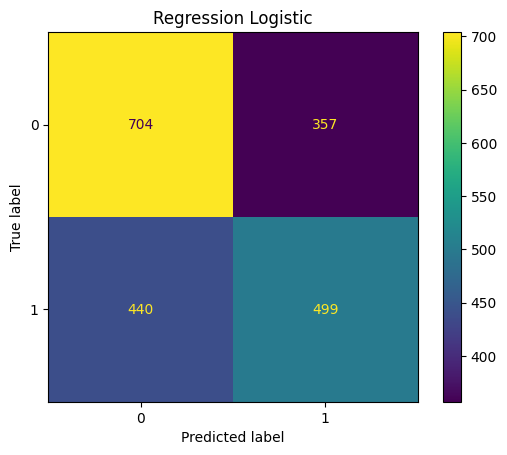

Gradient Boost               precision    recall  f1-score   support

           0       0.65      0.71      0.68      1061
           1       0.63      0.56      0.59       939

    accuracy                           0.64      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.64      0.64      2000



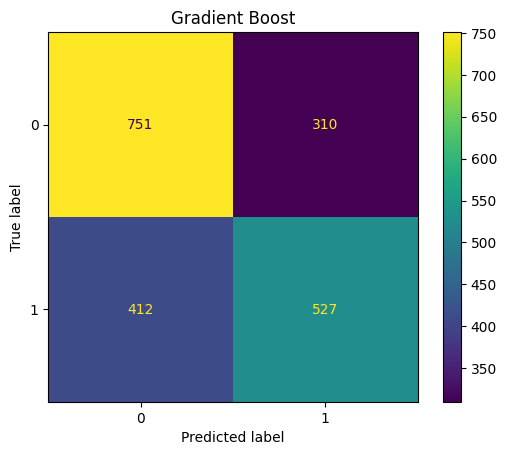

Random Forest               precision    recall  f1-score   support

           0       0.64      0.70      0.67      1061
           1       0.62      0.55      0.58       939

    accuracy                           0.63      2000
   macro avg       0.63      0.62      0.62      2000
weighted avg       0.63      0.63      0.63      2000



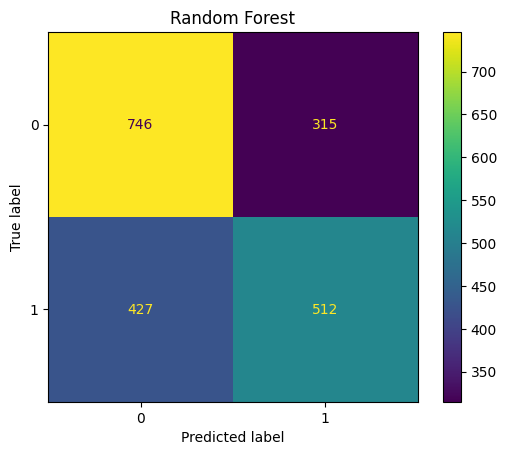

K-Nearest Neighbors               precision    recall  f1-score   support

           0       0.62      0.63      0.63      1061
           1       0.57      0.55      0.56       939

    accuracy                           0.60      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.60      0.60      0.60      2000



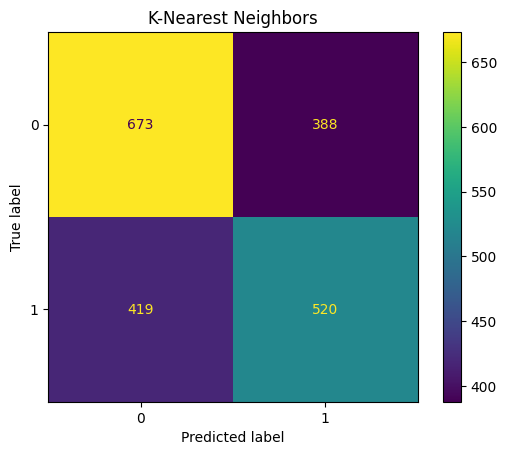

{'Regression Logistic': 0.6551146817307201,
 'Gradient Boost': 0.6927853543033626,
 'Random Forest': 0.6759662704925026,
 'K-Nearest Neighbors': 0.6266703403363917}

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

results = {}
for name, m in models.items():
    clf = Pipeline([('pre', pre), ('model', m)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_prob)
    results[name] = roc
    print(name, classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(name)
    plt.show()

results

# 6. Validation croisée  
Évaluation des modèles avec validation croisée pour robustesse.

In [10]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)
for name, m in models.items():
    clf = Pipeline([('pre', pre), ('model', m)])
    scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    print(name, scores.mean(), scores.std())

Regression Logistic 0.6574768714386232 0.01759680405359956
Gradient Boost 0.6880922914163603 0.015998257770698684
Gradient Boost 0.6880922914163603 0.015998257770698684
Random Forest 0.676643189307413 0.013263617499895537
Random Forest 0.676643189307413 0.013263617499895537
K-Nearest Neighbors 0.6295382116856825 0.00994787077637198
K-Nearest Neighbors 0.6295382116856825 0.00994787077637198


# Meilleur modèle : Gradient boost avec 0.68 de précision. 
Les données étant générées, la précision est acceptable. Avec des données réelles, on pourrait s'attendre à une précision plus élevée.